In [9]:
#!/usr/bin/env python
# coding: utf-8

# # Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond
# 
# In this iPython notebook I implement a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df
# 
# For more reinforcment learning tutorials, see:
# https://github.com/awjuliani/DeepRL-Agents

# In[1]:


from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
#get_ipython().run_line_magic('matplotlib', 'inline')


# ### Load the game environment

# Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

# In[2]:




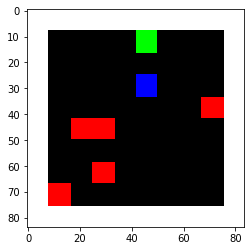

In [10]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=8)

In [11]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [12]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [13]:
def processState(states):
    return np.reshape(states,[21168])

In [14]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [15]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [16]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
500 -0.2 1
1000 -1.0 1
1500 -1.0 1
2000 0.0 1
2500 -1.7 1
3000 -0.7 1
3500 1.0 1
4000 -0.1 1
4500 1.3 1
5000 0.3 1
5500 -1.0 1
6000 -0.3 1
6500 1.6 1
7000 -0.1 1
7500 0.1 1
8000 0.4 1
8500 1.3 1
9000 -0.3 1
9500 -1.2 1
10000 -0.6 1


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv/Conv2D (defined at <ipython-input-11-8d953b9871a6>:8) ]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv/Conv2D (defined at <ipython-input-11-8d953b9871a6>:8) ]]
	 [[ArgMax/_91]]
0 successful operations.
0 derived errors ignored.

Errors may have originated from an input operation.
Input Source operations connected to node Conv/Conv2D:
 Reshape (defined at <ipython-input-11-8d953b9871a6>:6)

Input Source operations connected to node Conv/Conv2D:
 Reshape (defined at <ipython-input-11-8d953b9871a6>:6)

Original stack trace for 'Conv/Conv2D':
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\asyncio\base_events.py", line 442, in run_forever
    self._run_once()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\asyncio\base_events.py", line 1462, in _run_once
    handle._run()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\IPython\core\interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-eb3658efee38>", line 2, in <module>
    mainQN = Qnetwork(h_size)
  File "<ipython-input-11-8d953b9871a6>", line 8, in __init__
    inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1159, in convolution2d
    conv_dims=2)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\contrib\framework\python\ops\arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py", line 1057, in convolution
    outputs = layer.apply(inputs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1479, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\layers\base.py", line 537, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 634, in __call__
    outputs = call_fn(inputs, *args, **kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 146, in wrapper
    ), args, kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 446, in converted_call
    return _call_unconverted(f, args, kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 253, in _call_unconverted
    return f(*args, **kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 196, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1079, in __call__
    return self.conv_op(inp, filter)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 635, in __call__
    return self.call(inp, filter)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 234, in __call__
    name=self.name)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1953, in conv2d
    name=name)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1161, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "c:\users\assistant_2\anaconda3\envs\rl_test\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)

plt.plot(rMean)